In [6]:
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
import numpy as np

Batch_Size=40
Image_Size=256
Channels=3
Epochs=30

dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "D:/VSCode/AI & ML Project/Dataset/Grape",
    shuffle=True,
    image_size=(Image_Size,Image_Size),
    batch_size= Batch_Size
)

Found 4062 files belonging to 4 classes.


In [7]:
class_names= dataset.class_names
class_names

['Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy']

In [8]:
def get_dataset_split(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+val_split+test_split)==1
    ds_size= len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=10)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,test_ds,val_ds

train_ds,test_ds,val_ds = get_dataset_split(dataset)
print(len(train_ds),len(test_ds),len(val_ds))

81 11 10


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)#loading to cache memory to reduce training time
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

resize_and_rescale =tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size,Image_Size),#resizing
    layers.experimental.preprocessing.Rescaling(1.0/255)#normalizing
])

data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomZoom(0.3)
])

input_shape=(Batch_Size,Image_Size,Image_Size,Channels)
n_classes=4
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),#relu makes model non linear by converting negative values in feature map to 0
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

In [10]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

data=model.fit(
    train_ds,
    batch_size=Batch_Size,
    validation_data=val_ds,
    verbose=1,
    epochs=Epochs
)

Epoch 1/30
81/81 [==============================] - 136s 2s/step - loss: 1.1518 - accuracy: 0.4299 - val_loss: 0.7728 - val_accuracy: 0.6230
Epoch 2/30
81/81 [==============================] - 125s 2s/step - loss: 0.7582 - accuracy: 0.6825 - val_loss: 1.0349 - val_accuracy: 0.6099
Epoch 3/30
81/81 [==============================] - 124s 2s/step - loss: 0.4953 - accuracy: 0.7955 - val_loss: 0.4782 - val_accuracy: 0.8063
Epoch 4/30
81/81 [==============================] - 126s 2s/step - loss: 0.3828 - accuracy: 0.8464 - val_loss: 0.3177 - val_accuracy: 0.8665
Epoch 5/30
81/81 [==============================] - 138s 2s/step - loss: 0.3306 - accuracy: 0.8709 - val_loss: 0.3065 - val_accuracy: 0.8953
Epoch 6/30
81/81 [==============================] - 168s 2s/step - loss: 0.2488 - accuracy: 0.9069 - val_loss: 0.3270 - val_accuracy: 0.8639
Epoch 7/30
81/81 [==============================] - 172s 2s/step - loss: 0.3451 - accuracy: 0.8752 - val_loss: 0.3197 - val_accuracy: 0.8691
Epoch 8/30
81

In [11]:
model.save("D:/VSCode/AI & ML Project/models/grape")

INFO:tensorflow:Assets written to: D:/VSCode/AI & ML Project/models/grape\assets


INFO:tensorflow:Assets written to: D:/VSCode/AI & ML Project/models/grape\assets


In [12]:
scores=model.evaluate(test_ds)

11/11 [==============================] - 8s 306ms/step - loss: 0.0804 - accuracy: 0.9716


2/2 [==============================] - 1s 66ms/step
Predicted Disease Grape___Black_rot


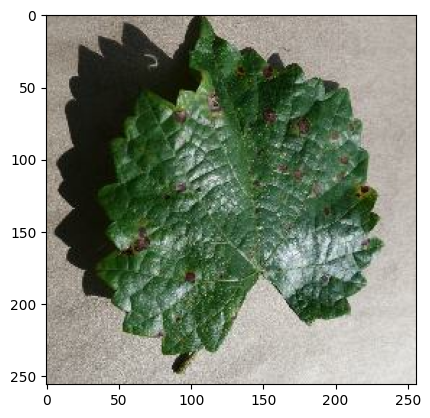

In [13]:
model=tf.keras.models.load_model("D:/VSCode/AI & ML Project/models/grape")

for images_batch,labels_batch in test_ds.take(1):
    image=images_batch[0].numpy().astype("uint8")
    plt.imshow(image)

batch_prediction= model.predict(images_batch)
print("Predicted Disease",class_names[np.argmax(batch_prediction[0])])